In [1]:
!jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import cv2
import torch
import imageio
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torch
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import Tensor
from itertools import compress, cycle
from collections import OrderedDict
from scipy.interpolate import griddata
from IPython.display import Image

from utils.utils import *

from utils.plotting import Plotter
from utils.gl_solver import GLSolver
from utils.parameters_init import ParametersInit
from utils.random_input_field import RandomInputField

import warnings
warnings.filterwarnings('ignore')

EPOCHS = 20_000
LR = 1
# SEED = 1234

# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.cuda.manual_seed_all(SEED)
# torch.set_default_tensor_type(torch.FloatTensor)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
path = "allinputnet-lenstest-2"
mtlibpath_prefix ="allinputnet-lenstest-2_mtl"

Nx=64
Ny=64

Lx= 60
Ly= 60
T_end = 1
dt = 0.005

myubatch_size = 32768

input_to_defect_ratio_sqrt = Nx // 4
N_ITERATIONS = int(T_end / dt)
A_norm, A_original, mem_rate, myu_original = compute_A_norm(
    Nx=Nx, 
    Ny=Ny, 
    input_to_defect_ratio=input_to_defect_ratio_sqrt*input_to_defect_ratio_sqrt, 
    mean=5.4, 
    std_deviation=0.8, 
    time_period=25, 
    Lx=Lx, 
    Ly=Ly, 
    dt=dt, 
    T_End=T_end, 
    parallel_runs=1, 
    input_scale=0.75, 
    mem_coef=1, 
    time_period_parameter=100, 
    _mean=5.4, 
    std_deviation_run_computation=1,
    input_myu=None
)

100%|██████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2049.43it/s]

Unique Myus count	 32
Max value of myu:	 98.85197228271444
Min value of myu:	 31.88124086517815
Unique values: [31.88124086517815, 37.359270372192285, 40.403393621893414, 43.05756207168323, 45.98773341353644, 49.24367785201386, 49.33108518051292, 50.32473718921848, 51.80089933009742, 56.206769050891836, 60.39270494769152, 60.628204306295025, 60.752503108835015, 60.9228661289371, 61.43770738474606, 61.48702528832784, 64.88013229482216, 65.00817838529062, 66.26218339532609, 68.17196198382413, 72.46314655157944, 73.32744083352007, 74.15451752168602, 74.76602992793298, 77.67698489736703, 79.04849442903783, 79.56678379997396, 79.86160873696112, 82.70099631570164, 86.0218134857251, 86.88102652417446, 98.85197228271444]
Counts:		 [25600 25600 25600 25600 25600 25600 25600 25600 25600 25600 25600 25600
 25600 25600 25600 25600 25600 25600 25600 25600 25600 25600 25600 25600
 25600 25600 25600 25600 25600 25600 25600 25600]
A.shape=(1, 200, 64, 64),
Myu.shape=(1, 200, 64, 64),

Any NaN values i

In [4]:
def output_plot(data, mem_rat, save_fig=False, file_name="A_in_norm_80%04d.png"):
    fig = plt.figure(1, figsize=(6.5, 6.5))
    for index in tqdm(range(mem_rat)):
        if index % 2 == 0:
            plt.clf()
            plt.imshow(data[index, :, :], origin='lower', vmax=0.9*np.max(data))
            plt.colorbar()
            if save_fig:
                filename = file_name % (index/2)
                plt.savefig(filename)

100%|████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 64.50it/s]


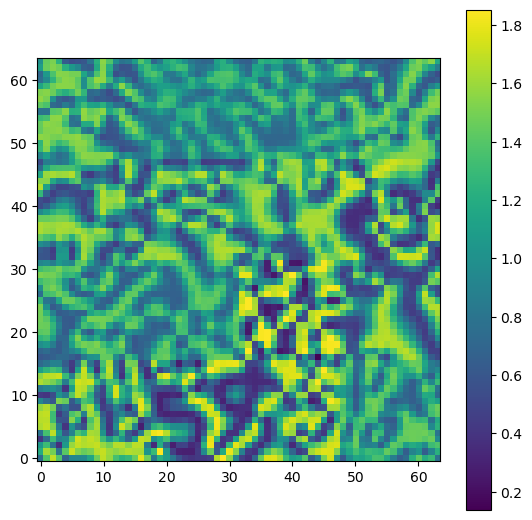

In [5]:
output_plot(A_norm, mem_rate)

GETTING HANDS DIRTY WITH THE NEURAL NETWORKS

In [6]:
x = np.linspace(0, 4, Nx).flatten()[:, None] - 2
y = np.linspace(0, 4, Ny).flatten()[:, None] - 2
t = np.linspace(0, T_end, N_ITERATIONS).flatten()[:, None]
X, T, Y = np.meshgrid(x, t, y)

Exact = A_original.squeeze(0)


X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()
u_star = np.hstack([u_star.real[:, None],u_star.imag[:, None]])

$$
\begin{aligned}
\partial_{t} A &= \mu A+\Delta A-|A|^{2} A
\end{aligned}
$$

In [7]:
class ALLINPUTNET(nn.Module):
    def __init__(self, layers_list, activation_function_list = None, linm = None):
        super(ALLINPUTNET, self).__init__()
        self._depth = len(layers_list) - 1
        
        if activation_function_list is None:
            activation_function_list = [F.softplus for _ in range(self._depth - 1)]
            
        if linm is None:
            linm =  np.tril(np.ones(self._depth + 1, dtype = int))
        lin = linm@layers_list
        
        self._activation_function_list = activation_function_list
        
        self._Wtmx = nn.Sequential(*[torch.nn.Linear(lin[i], layers_list[i+1], dtype = torch.float64) for i in range(self._depth)])
        self._linm = linm
        
        self.optimizer = torch.optim.Adam( params = self._Wtmx.parameters(), lr=0.01 )    
        
    def forward(self, x):
        layers = [x,self._Wtmx[0](x)]
        for i in range(1, self._depth):
            layers[i] = self._activation_function_list[i-1](layers[i])
            ind = self._linm[i]
            inpind = np.where(ind)[0]
            inp = torch.concat([layers[i] for i in inpind], dim = -1)
            layers.append(self._Wtmx[i](inp))
        return layers[-1]        

    def predict(self, x):
        self._Wtmx.eval()
        if type(x) is not torch.Tensor:
            x = torch.tensor(x, dtype = torch.float64).to(device)
        y =  self.forward(x).cpu().detach().numpy()
        return y[:,0] + y[:,1]*1j    

    def rmsef(self, y, y_pred):
        mseloss = torch.sum((y_pred - y)**2, dim = 1)
        return torch.mean(torch.sqrt(mseloss))   

    def msef(self, y, y_pred):
        return torch.mean((y_pred - y)**2)       

    def fastmsebatchtrain(self, x, y, epochs=100, batch_size = 64):
        
        x = torch.tensor(x, dtype = torch.float64).to(device)
        y = torch.tensor(y, dtype = torch.float64).to(device)
        dataloader = DataLoader(dataset = torch.hstack((x,y)), batch_size=batch_size, shuffle=True)
        
        self.optimizer.zero_grad()
        L = []
        
        pbar = tqdm(total=epochs)
        try:
            while True:
                if pbar.n >= epochs:
                    break
                for tmp in dataloader:
                    (tmpx, tmpy, tmpt, tmpu_real, tmpu_img) = tmp.T
                    X = torch.stack((tmpx,tmpy,tmpt)).T
                    U = torch.stack((tmpu_real, tmpu_img)).T

                    y_pred = self.forward(X)
                    loss = self.msef(y_pred,U)
                    L.append(loss.cpu().detach().numpy())
                    loss.backward()
                    self.optimizer.step()
                    self._Wtmx.zero_grad()
                    self.optimizer.zero_grad()
                    # Update the progress bar
                    if pbar.n >= epochs:
                        break
                    pbar.update(1)
                        
        except Exception as e:
            raise Exception(e)
        finally:
            # Close the progress bar
            pbar.close()          
        return L
    
    def fastrmsebatchtrain(self, x, y, epochs=100, batch_size = 64):
        
        x = torch.tensor(x, dtype = torch.float64).to(device)
        y = torch.tensor(y, dtype = torch.float64).to(device)
        dataloader = DataLoader(dataset = torch.hstack((x,y)), batch_size=batch_size, shuffle=True)
        
        self.optimizer.zero_grad()
        L = []
        
        pbar = tqdm(total=epochs)
        try:
            while True:
                if pbar.n >= epochs:
                    break
                for tmp in dataloader:
                    (tmpx, tmpy, tmpt, tmpu_real, tmpu_img) = tmp.T
                    X = torch.stack((tmpx,tmpy,tmpt)).T
                    U = torch.stack((tmpu_real, tmpu_img)).T

                    y_pred = self.forward(X)
                    loss = self.rmsef(y_pred,U)
                    L.append(loss.cpu().detach().numpy())
                    loss.backward()
                    self.optimizer.step()
                    self._Wtmx.zero_grad()
                    self.optimizer.zero_grad()
                    # Update the progress bar
                    if pbar.n >= epochs:
                        break
                    pbar.update(1)
                        
        except Exception as e:
            raise Exception(e)
        finally:
            # Close the progress bar
            pbar.close()          
        return L

In [8]:
class ALLINPUTPINN(ALLINPUTNET):
    def __init__(self,*args,**kwargs):
        super(ALLINPUTPINN, self).__init__(*args,**kwargs)
#         myu = torch.randn(4, 2, dtype=torch.float64).to(device)
#         myu = nn.Parameter(myu)
#         self._Wtmx.register_parameter('myu', myu)
#         self.myuparam = myu
#         myu = transform_and_stack(myu, 4, 200).to(device).clone().requires_grad_(True)
#         self.myu = myu.view(200, 4, 4)
        self.myureset()
    
    def myureset(self):
        myu = torch.randn(mem_rate, Nx//input_to_defect_ratio_sqrt, Ny//input_to_defect_ratio_sqrt, dtype=torch.float64).to(device)
        myu = nn.Parameter(myu)
        self.myuparam = myu
        self._Wtmx.register_parameter('myu', myu)
        
    @property
    def myu(self):
        myu = F.interpolate(self.myuparam.unsqueeze(0), scale_factor=input_to_defect_ratio_sqrt, mode='nearest').squeeze()
        return myu
    
    def loaddata_precalculate(self,x):
        myuloss = MYULOSS(*tuple(x.T),self)
        myuloss.calculate_f_withoutmyu()
        self.myuloss = myuloss
    
    def fmsef(self, myu):
        return self.myuloss.fmse(myu)
    
    def fmse(self):
        return self.fmsef(self.myu)
    
    def myutrain(self, epochs=100, lr = 0.01):
        
        myuoptimizer = torch.optim.Adam( params = [self.myuparam], lr=lr ) 
        myuoptimizer.zero_grad()

        for _ in tqdm(range(epochs)):
            self.fmse().backward(retain_graph=True)
            myuoptimizer.step()
            myuoptimizer.zero_grad()
        
        FMSE = self.myuloss.FMSE
        self.myuloss.clear()
        return FMSE

In [9]:
class MYULOSS:
  def __init__(self, x, y, t, net, verbose = 0):
      self.msef = nn.MSELoss()
      self.FMSE = []
      self.x = x
      self.y = y
      self.t = t
      self.net = net
        
  def plot(self, title= 'MYU training'):
    plt.plot(self.FMSE)
    plt.yscale('log')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('FMSE')
    self.clear()
    
  def clear(self):
    self.FMSE = []
    
  def fmse(self, myu):
    f_loss = torch.mean(torch.abs(self.net_f(myu)) ** 2)
    self.FMSE.append(f_loss.cpu().detach().numpy())
    return f_loss
  
  def net_f(self, myu, verbose = 0):
        return self.f_withoutmyu - myu*self.u 
    
  def calculate_f_withoutmyu(self):
        x,y,t = self.x, self.y, self.t
        
        u, u_t,u_xx,u_yy = MYULOSS.pref(x,y,t,net)
        
        self.u = u.cpu().detach()
            
        f_withoutmyu = u_t - (u_xx + u_yy) + torch.pow(torch.abs(u), 2)*u #- myu*u
        self.f_withoutmyu = f_withoutmyu.cpu().detach()
        free_memory(u_t, u_xx, u_yy, u, f_withoutmyu)

    
  def f_withoutmyu(x,y,t,ru,iu):
        (ru_t, ru_x, ru_y) = torch.autograd.grad(ru, (t, x, y), grad_outputs=torch.ones_like(ru), create_graph=True, retain_graph=True)
        (iu_t, iu_x, iu_y) = torch.autograd.grad(iu, (t, x, y), grad_outputs=torch.ones_like(iu), create_graph=True, retain_graph=True)

        (ru_xx,) = torch.autograd.grad(ru_x, (x), grad_outputs=torch.ones_like(ru_x), create_graph=True)
        (iu_xx,) = torch.autograd.grad(iu_x, (x), grad_outputs=torch.ones_like(iu_x), create_graph=True)

        (ru_yy,) = torch.autograd.grad(ru_y, (y), grad_outputs=torch.ones_like(ru_y), create_graph=True)
        (iu_yy,) = torch.autograd.grad(iu_y, (y), grad_outputs=torch.ones_like(iu_y), create_graph=True)

        u =( ru + iu * 1j)
        u_t = (ru_t + iu_t * 1j)
        u_xx =( ru_xx + iu_xx *1j)
        u_yy = (ru_yy + iu_yy *1j)
        
        return u, u_t,u_xx,u_yy
    
  def pref(x,y,t, net, batch_size = myubatch_size):
    dataloader = DataLoader(dataset = X_star, batch_size = batch_size, shuffle=False)
    cache = {
        'u':[],
        'u_t':[],
        'u_xx':[],
        'u_yy':[],
    }
    for tmp in tqdm(dataloader):
        x,y,t = torch.tensor(tmp.T, dtype = torch.float64, requires_grad=True).to(device)
        ru,iu = net.forward(torch.stack((x,y,t)).T).T
        u, u_t,u_xx,u_yy = MYULOSS.f_withoutmyu(x,y,t,ru,iu)
        cache['u'].append(u.cpu().detach())
        cache['u_t'].append(u_t.cpu().detach())
        cache['u_xx'].append(u_xx.cpu().detach())
        cache['u_yy'].append(u_yy.cpu().detach())
        
    return  torch.cat(cache['u']).view(mem_rate, Nx, Ny), \
            torch.cat(cache['u_t']).view(mem_rate, Nx, Ny),\
            torch.cat(cache['u_xx']).view(mem_rate, Nx, Ny),\
            torch.cat(cache['u_yy']).view(mem_rate, Nx, Ny)

      
def free_memory(*variables):
    del variables
    torch.cuda.empty_cache()

In [10]:
def fastrmselensbatchtrain(net1,net2, x, y, spread = 1, epochs=100, batch_size = 64):

    x = torch.tensor(x, dtype = torch.float64).to(device)
    y = torch.tensor(y, dtype = torch.float64).to(device)
    dataloader = DataLoader(dataset = torch.hstack((x,y)), batch_size=batch_size, shuffle=True)

    net1.optimizer.zero_grad()
    net2.optimizer.zero_grad()
    L = []

    pbar = tqdm(total=epochs)
    try:
        while True:
            if pbar.n >= epochs:
                break
            for tmp in dataloader:
                (tmpx, tmpy, tmpt, tmpu_real, tmpu_img) = tmp.T
                Xsm = torch.stack((tmpx / spread,tmpy / spread,tmpt)).T
                Xbg = torch.stack((tmpx * spread,tmpy * spread,tmpt)).T
                
                U = torch.stack((tmpu_real, tmpu_img)).T

                y_pred = net1.forward(Xsm) * net2.forward(Xbg)
                loss = net1.rmsef(y_pred,U)
                L.append(loss.cpu().detach().numpy())
                loss.backward()
                net1.optimizer.step()
                net2.optimizer.step()
                net1._Wtmx.zero_grad()
                net2._Wtmx.zero_grad()
                net1.optimizer.zero_grad()
                net2.optimizer.zero_grad()
                # Update the progress bar
                if pbar.n >= epochs:
                    break
                pbar.update(1)

    except Exception as e:
        raise Exception(e)
    finally:
        # Close the progress bar
        pbar.close()          
    return L

In [11]:
torch.manual_seed(0)
device = 'cpu'
default = [3,8,32,64,32,8,2]
spread = 1
current = [3,32,32,60,32,8,2]

x = np.linspace(0, 4, Nx).flatten()[:, None] - 2
y = np.linspace(0, 4, Ny).flatten()[:, None] - 2
X, T, Y = np.meshgrid(x, t, y)
X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]))


net1 = ALLINPUTPINN(current).to(device)
net2 = ALLINPUTPINN(current).to(device)

In [12]:
net1.optimizer.param_groups[0]['lr'] = 0.03
net2.optimizer.param_groups[0]['lr'] = 0.03
L1 = fastrmselensbatchtrain(net1,net2, x = X_star, y = u_star, spread= spread, epochs = 50000)

100%|███████████████████████████████████████████████████████████████████████| 50000/50000 [01:45<00:00, 472.32it/s]


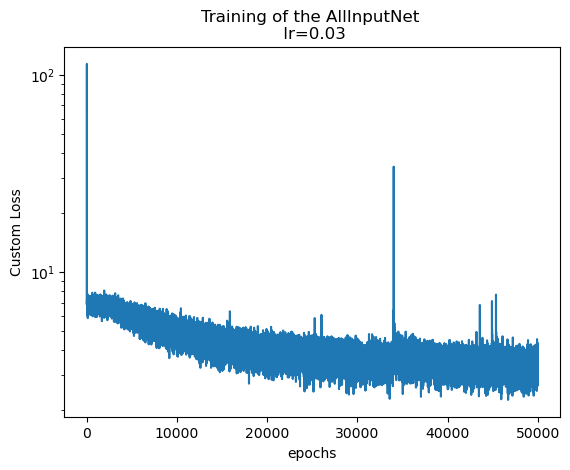

In [13]:
plt.plot(L1)
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('Custom Loss')
plt.title('Training of the AllInputNet \n lr=0.03')
plt.savefig(f'{mtlibpath_prefix}_allinputnet003.png')

In [14]:
net1.optimizer.param_groups[0]['lr'] = 0.01
net2.optimizer.param_groups[0]['lr'] = 0.01
L2 = fastrmselensbatchtrain(net1,net2, x = X_star, y = u_star, spread= spread, epochs = 50000)

100%|███████████████████████████████████████████████████████████████████████| 50000/50000 [01:42<00:00, 489.91it/s]


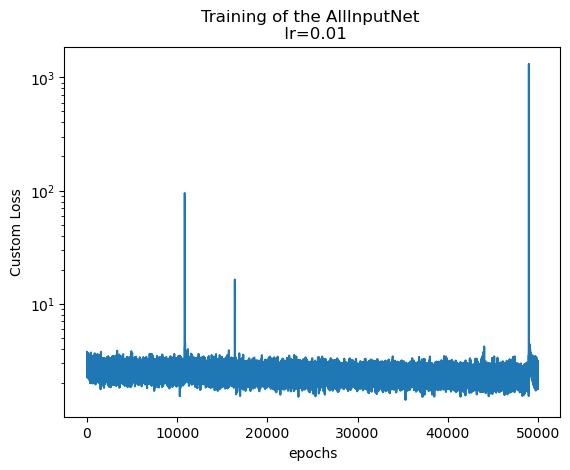

In [15]:
plt.plot(L2)
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('Custom Loss')
plt.title('Training of the AllInputNet \n lr=0.01')
plt.savefig(f'{mtlibpath_prefix}_allinputnet001.png')

In [16]:
a1 = net1.predict(X_star / spread)
a2 = net2.predict(X_star * spread)
A2 = (np.real(a1) * np.real(a2) + 1j*(np.imag(a1)*np.imag(a2))).reshape(A_original.shape)
import seaborn as sns
sns.heatmap(((np.real(A2)*np.imag(A2)))[0][-3])
plt.show()
sns.heatmap(((np.real(A_original)*np.imag(A_original)).reshape(A_original.shape))[0][-])


SyntaxError: invalid syntax (2523714463.py, line 7)

In [ ]:
plt.plot(L2)
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('Custom Loss')
plt.title('Training of the AllInputNet \n lr=0.005')
plt.savefig(f'{mtlibpath_prefix}_allinputnet0005.png')

In [ ]:
create_gifs(
    memory_rate=mem_rate,
    u_pred=A2,
    original=A_original,
    save=True,
    path_for_gif=path+".gif",
    duration=500,
    title=" "
)
Image(filename=path+".gif")

In [ ]:
path